In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import OpenEXR
import Imath
import array


In [8]:
# File paths
depth_filepath = 'data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=depth/front_upper/2025-08-05_173119/000001.exr'
img_filepath = 'data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=image/front_upper/2025-08-04_203708/000001.png'

# Chosen point (normalized coordinates)
x_delta = 0.5  # Center of frame horizontally
y_delta = 0.5  # Center of frame vertically


In [9]:
def read_exr_depth(filepath):
    """Read depth data from EXR file"""
    file = OpenEXR.InputFile(filepath)
    header = file.header()
    
    # Get image dimensions
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    # Read depth channel (usually 'Z' or 'R' for single channel depth)
    channels = header['channels'].keys()
    print(f"Channels: {channels}")
    if 'Z' in channels:
        depth_channel = 'Z'
    elif 'R' in channels:
        depth_channel = 'R'
    else:
        depth_channel = list(channels)[0]  # Use first available channel
    
    depth_str = file.channel(depth_channel, Imath.PixelType(Imath.PixelType.FLOAT))
    depth = array.array('f', depth_str)
    depth = np.array(depth).reshape((height, width))
    
    return depth, width, height


In [10]:
# Load image and depth map
img = Image.open(img_filepath)
img_array = np.array(img)

depth_map, depth_width, depth_height = read_exr_depth(depth_filepath)

print(f"Image dimensions: {img.size}")
print(f"Depth map dimensions: {depth_width} x {depth_height}")
print(f"Depth range: {depth_map.min():.3f} - {depth_map.max():.3f} meters")


Channels: dict_keys(['B', 'G', 'R'])
Image dimensions: (1920, 1080)
Depth map dimensions: 1920 x 1080
Depth range: 1.055 - 4.339 meters


In [11]:
# Convert normalized coordinates to pixel coordinates
img_width, img_height = img.size
x_pixel = int(x_delta * img_width)
y_pixel = int(y_delta * img_height)

# For depth map coordinates (in case dimensions differ)
x_depth_pixel = int(x_delta * depth_width)
y_depth_pixel = int(y_delta * depth_height)

# Get distance at chosen point
distance_meters = depth_map[y_depth_pixel, x_depth_pixel]

print(f"Chosen point coordinates:")
print(f"  Image: ({x_pixel}, {y_pixel}) pixels")
print(f"  Depth: ({x_depth_pixel}, {y_depth_pixel}) pixels")
print(f"Distance from viewer: {distance_meters:.3f} meters")


Chosen point coordinates:
  Image: (960, 540) pixels
  Depth: (960, 540) pixels
Distance from viewer: 2.941 meters


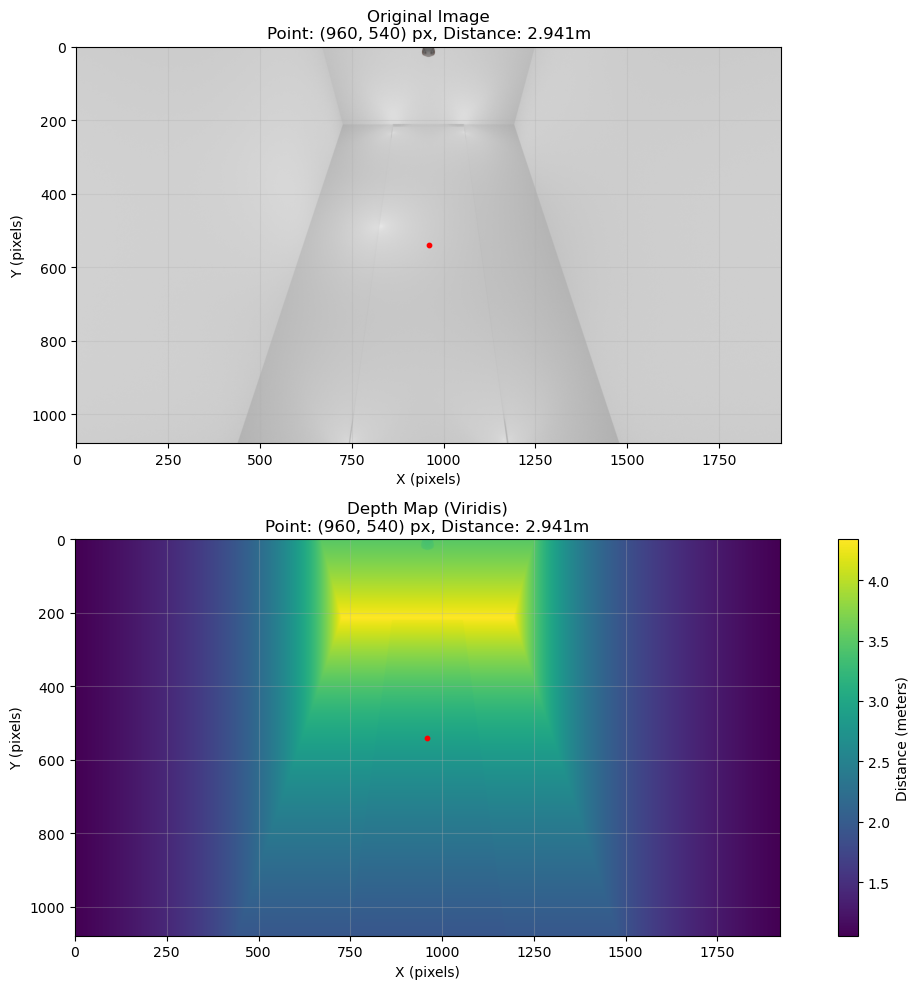

In [15]:
# Create visualization
DOT_SIZE = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original image
ax1.imshow(img_array)
ax1.scatter(x_pixel, y_pixel, c='red', s=DOT_SIZE, marker='o')
ax1.set_title(f'Original Image\nPoint: ({x_pixel}, {y_pixel}) px, Distance: {distance_meters:.3f}m')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.grid(True, alpha=0.3)

# Bottom plot: Depth map
depth_plot = ax2.imshow(depth_map, cmap='viridis')
ax2.scatter(x_depth_pixel, y_depth_pixel, c='red', s=DOT_SIZE, marker='o')
ax2.set_title(f'Depth Map (Viridis)\nPoint: ({x_depth_pixel}, {y_depth_pixel}) px, Distance: {distance_meters:.3f}m')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')

# Add colorbar for depth map
cbar = plt.colorbar(depth_plot, ax=ax2)
cbar.set_label('Distance (meters)')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# Additional analysis
print("\n=== Analysis Summary ===")
print(f"Chosen normalized coordinates: ({x_delta}, {y_delta})")
print(f"Pixel coordinates in image: ({x_pixel}, {y_pixel})")
print(f"Pixel coordinates in depth map: ({x_depth_pixel}, {y_depth_pixel})")
print(f"Distance to surface: {distance_meters:.3f} meters")
print(f"Depth map statistics:")
print(f"  - Min distance: {depth_map.min():.3f}m")
print(f"  - Max distance: {depth_map.max():.3f}m")
print(f"  - Mean distance: {depth_map.mean():.3f}m")
print(f"  - Std deviation: {depth_map.std():.3f}m")



=== Analysis Summary ===
Chosen normalized coordinates: (0.5, 0.5)
Pixel coordinates in image: (960, 540)
Pixel coordinates in depth map: (960, 540)
Distance to surface: 2.941 meters
Depth map statistics:
  - Min distance: 1.055m
  - Max distance: 4.339m
  - Mean distance: 2.136m
  - Std deviation: 0.847m
